In [215]:
import os
import pandas as pd
from langchain_openai import ChatOpenAI
from langchain.output_parsers import PydanticOutputParser
from langchain.prompts import PromptTemplate
from pydantic import BaseModel, Field, NonNegativeInt
from typing import List
from fastapi.encoders import jsonable_encoder
from diffusers import DiffusionPipeline, AutoPipelineForText2Image
import torch

In [199]:
OPEN_API_KEY = "voc-1048144063126677352186866eb2d2063b232.91617594"
BASE_URL = "https://openai.vocareum.com/v1"
GPT_MODEL = "gpt-4o-mini-2024-07-18"

In [207]:
llm = ChatOpenAI(model=GPT_MODEL, temperature=0, base_url = BASE_URL, api_key = OPEN_API_KEY)

task = "Generate ten diverse real estate listings based on the sample listing below: "
sample_listing = '''
Sample Listing : 

Neighborhood: Green Oaks
Price: $800000
Bedrooms: 3
Bathrooms: 2
House Size: 2000 sqft

Description: Welcome to this eco-friendly oasis nestled in the heart of Green Oaks. This charming 3-bedroom, 2-bathroom home boasts energy-efficient features such as solar panels and a well-insulated structure. Natural light floods the living spaces, highlighting the beautiful hardwood floors and eco-conscious finishes. The open-concept kitchen and dining area lead to a spacious backyard with a vegetable garden, perfect for the eco-conscious family. Embrace sustainable living without compromising on style in this Green Oaks gem.

Neighborhood Description: Green Oaks is a close-knit, environmentally-conscious community with access to organic grocery stores, community gardens, and bike paths. Take a stroll through the nearby Green Oaks Park or grab a cup of coffee at the cozy Green Bean Cafe. With easy access to public transportation and bike lanes, commuting is a breeze.
'''


In [208]:
class RealEstateListing(BaseModel):
    neighborhood: str = Field(description="The name of the neighborhood where the property is located")
    price: NonNegativeInt = Field(description="Price of the property in USD")
    bedrooms: NonNegativeInt = Field(description="Number of bedrooms in the property")
    bathrooms: NonNegativeInt = Field(description="Number of bathrooms in the property")
    house_size: NonNegativeInt = Field(description="Size of the property in square feet")
    description: str = Field(description="Description of the property")
    neighborhood_description: str = Field(description="Description of the neighborhood")

class ListingsCollection(BaseModel):
    listings: List[RealEstateListing] = Field(description="List of Real Estate Listings")

parser = PydanticOutputParser(pydantic_object=ListingsCollection)

In [209]:
prompt = PromptTemplate(
    template="{task}\n{sample_listing}\n\n{format_instructions}",
    input_variables=["task, sample_listing"],
    partial_variables={"format_instructions": parser.get_format_instructions},
)
query = prompt.format(task=task, sample_listing=sample_listing)
print(query)

Generate ten diverse real estate listings based on the sample listing below: 

Sample Listing : 

Neighborhood: Green Oaks
Price: $800000
Bedrooms: 3
Bathrooms: 2
House Size: 2000 sqft

Description: Welcome to this eco-friendly oasis nestled in the heart of Green Oaks. This charming 3-bedroom, 2-bathroom home boasts energy-efficient features such as solar panels and a well-insulated structure. Natural light floods the living spaces, highlighting the beautiful hardwood floors and eco-conscious finishes. The open-concept kitchen and dining area lead to a spacious backyard with a vegetable garden, perfect for the eco-conscious family. Embrace sustainable living without compromising on style in this Green Oaks gem.

Neighborhood Description: Green Oaks is a close-knit, environmentally-conscious community with access to organic grocery stores, community gardens, and bike paths. Take a stroll through the nearby Green Oaks Park or grab a cup of coffee at the cozy Green Bean Cafe. With easy ac

In [210]:
response = llm(query)

In [211]:
result = parser.parse(response.content)
df = pd.DataFrame(jsonable_encoder(result.listings))
df

,neighborhood,price,bedrooms,bathrooms,house_size,description,neighborhood_description
0,Sunnyvale,650000,4,3,2500,"Discover this spacious 4-bedroom, 3-bathroom f...",Sunnyvale is a vibrant community known for its...
1,Lakeside,1200000,5,4,3500,"This stunning 5-bedroom, 4-bathroom home offer...",Lakeside is an upscale neighborhood known for ...
2,Downtown,900000,2,2,1500,Experience urban living in this chic 2-bedroom...,Downtown is a bustling area filled with cultur...
3,Maplewood,750000,3,2,2200,"Welcome to this charming 3-bedroom, 2-bathroom...",Maplewood is a family-oriented neighborhood kn...
4,Hilltop,850000,4,3,2800,"This beautiful 4-bedroom, 3-bathroom home in H...",Hilltop is known for its scenic views and tran...
5,Riverside,700000,3,2,1800,"This delightful 3-bedroom, 2-bathroom home in ...",Riverside is a picturesque neighborhood with a...
6,Cedar Grove,950000,5,4,3200,"This luxurious 5-bedroom, 4-bathroom home in C...",Cedar Grove is an affluent neighborhood known ...
7,Westfield,600000,2,1,1200,"This cozy 2-bedroom, 1-bathroom bungalow in We...",Westfield is a friendly neighborhood with a sm...
8,Forest Hill,1100000,4,3,3000,"This stunning 4-bedroom, 3-bathroom home in Fo...",Forest Hill is an upscale neighborhood known f...
9,Oceanview,1300000,3,2,2000,"This breathtaking 3-bedroom, 2-bathroom beach ...",Oceanview is a vibrant coastal community known...


In [212]:
df.to_csv('listings.csv',index_label = 'id')

In [3]:
df = pd.read_csv("listings.csv")
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [4]:
pipe = AutoPipelineForText2Image.from_pretrained(
    "stabilityai/sdxl-turbo",
    torch_dtype=torch.float16, 
    variant="fp16"
).to(device)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [5]:
prompt = "An 8k high detailed image of a real estate listing with the following property description:\n{}"
images = []

for index, _ in df.iterrows():
    rand_gen = torch.manual_seed(837439186)
    image = pipe(
        prompt=prompt.format(df['description'].iloc[index]), 
        num_inference_steps=3, 
        guidance_scale=1.0, 
        negative_prompt=["overexposed", "underexposed"], 
        generator=rand_gen
    ).images[0]
    images.append(image)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Discover this spacious 4-bedroom, 3-bathroom family home in Sunnyvale. Featuring an open floor plan, modern kitchen with stainless steel appliances, and a cozy fireplace in the living room. The large backyard is perfect for entertaining, complete with a patio and play area for kids.


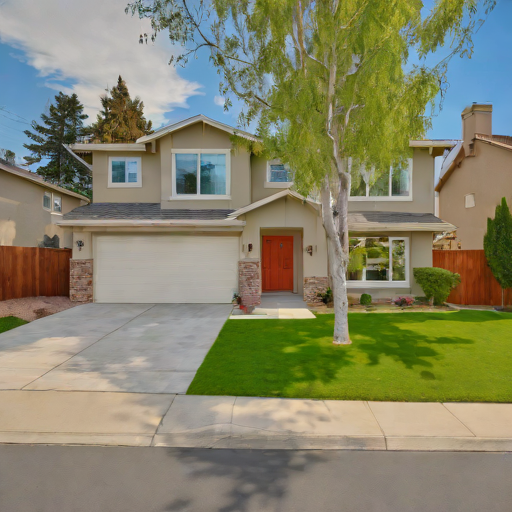




This stunning 5-bedroom, 4-bathroom home offers breathtaking lake views and luxurious finishes. The gourmet kitchen features granite countertops and a large island, while the master suite includes a private balcony. Enjoy outdoor living with a spacious deck and landscaped yard.


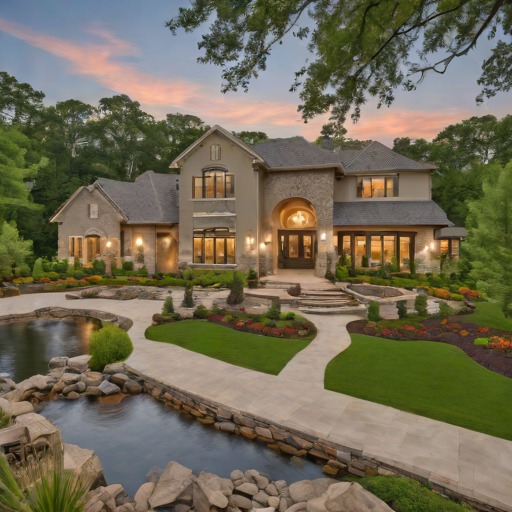




Experience urban living in this chic 2-bedroom, 2-bathroom condo in the heart of Downtown. With floor-to-ceiling windows, modern finishes, and an open layout, this space is perfect for city dwellers. Enjoy amenities like a rooftop pool and fitness center.


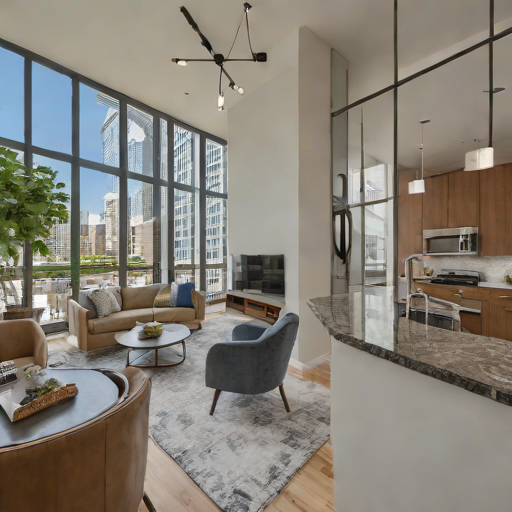




Welcome to this charming 3-bedroom, 2-bathroom home in Maplewood. Featuring a traditional layout with a modern twist, this property includes a renovated kitchen, a cozy den, and a large backyard with mature trees and a fire pit.


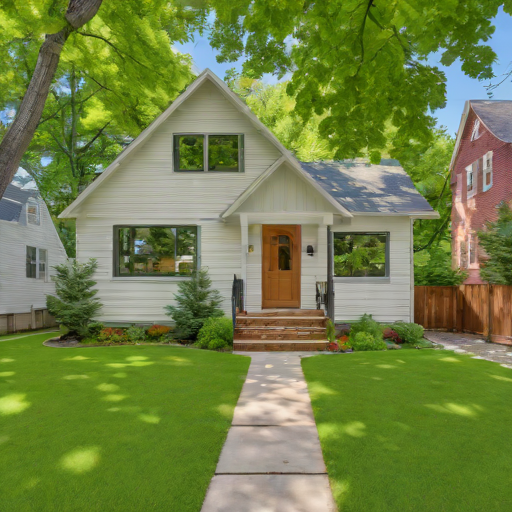




This beautiful 4-bedroom, 3-bathroom home in Hilltop features panoramic views and a spacious layout. The gourmet kitchen opens to a large family room, and the master suite includes a luxurious bathroom. The outdoor space is perfect for entertaining.


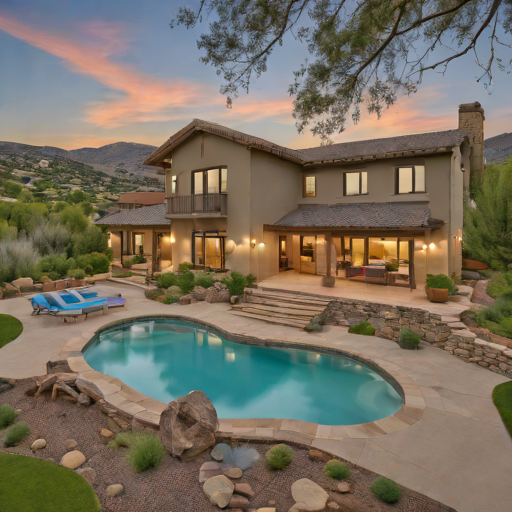

In [10]:
for i in range(0, 5):
    print(df['description'].iloc[i])
    display(images[i])
    print("\n\n")

In [11]:
images_dir = 'images'

# Create image directory
if not os.path.exists(images_dir):
    os.makedirs(images_dir)
# Save each image
for i, image in enumerate(images):
    filename = os.path.join(images_dir, str(i) + ".png")
    image.save(filename)